In [57]:
import matplotlib.pyplot as plt

In [58]:
import pandas as pd
import visuals as vs
import numpy as np
import seaborn as sns
import graph_visuals as gv

# train data
train_df = pd.read_csv("Powersell-train.csv", parse_dates=['Date of First Contact', 'Date of Giving Proposal', 'Date of Closing'])
train_df = train_df.rename(columns=lambda x: x.strip())

test_df = pd.read_csv("Powersell-test.csv", parse_dates=['Date of First Contact', 'Date of Giving Proposal', 'Date of Closing'])
test_df = test_df.rename(columns=lambda x: x.strip())

In [59]:
# train
propensity = train_df["Propensity"]
train_data = train_df.drop(["Propensity", "Opportunity Number"], axis=1)

# test
test_data = test_df.drop(["Propensity", "Opportunity Number"], axis=1)

In [60]:
train_data['Date of First Contact'] = train_data['Date of First Contact'].apply(lambda x: x.strftime("%Y-%m-%d"))
train_data['Date of Giving Proposal'] = train_data['Date of Giving Proposal'].apply(lambda x: x.strftime("%Y-%m-%d"))
train_data['Date of Closing'] = train_data['Date of Closing'].apply(lambda x: x.strftime("%Y-%m-%d"))
 
test_data['Date of First Contact'] = test_data['Date of First Contact'].apply(lambda x: x.strftime("%Y-%m-%d"))
test_data['Date of Giving Proposal'] = test_data['Date of Giving Proposal'].apply(lambda x: x.strftime("%Y-%m-%d"))
test_data['Date of Closing'] = test_data['Date of Closing'].apply(lambda x: x.strftime("%Y-%m-%d"))

In [61]:
from datetime import datetime

def dates_feature_eng(data, source_column):
    t1 = 'Day ' + ' '.join(source_column.split(' ')[1:])
    t2 = 'Month ' + ' '.join(source_column.split(' ')[1:])
    
    days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
    data[t1] = data[source_column].map(day_of_week)
    data[t1] = data[t1].apply(lambda x: days[x])
    
    month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
    data[t2] = data[source_column].map(month)
    
    data[t2] = data[t2].apply(lambda x: months[x-1])
    
    return data

train_set = dates_feature_eng(train_data, 'Date of First Contact')
train_set = dates_feature_eng(train_data, 'Date of Giving Proposal')
train_set = dates_feature_eng(train_data, 'Date of Closing')

test_set = dates_feature_eng(train_data, 'Date of First Contact')
test_set = dates_feature_eng(train_data, 'Date of Giving Proposal')
test_set = dates_feature_eng(train_data, 'Date of Closing')

In [62]:
train_set_dates_dropped = train_set.drop(['Date of First Contact', 'Date of Giving Proposal', 'Date of Closing'], axis=1)

test_set_dates_dropped = test_set.drop(['Date of First Contact', 'Date of Giving Proposal', 'Date of Closing'], axis=1)

In [63]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['Number of Contacts', 'Opportunity Amount (in USD)', 'Anonymous Variable 1', 'Anonymous Variable 2', 'Anonymous Variable 3', 'Anonymous Variable 4']

train_features_log_minmax_transform = pd.DataFrame(data = train_set_dates_dropped)
train_features_log_minmax_transform[numerical] = scaler.fit_transform(train_set_dates_dropped[numerical])

# test
test_features_log_minmax_transform = pd.DataFrame(data = test_set_dates_dropped)
test_features_log_minmax_transform[numerical] = scaler.fit_transform(test_set_dates_dropped[numerical])

In [64]:
train_final_features = pd.get_dummies(train_features_log_minmax_transform)
train_encoded = list(train_final_features.columns)
print("{} total features after one-hot encoding.".format(len(train_encoded)))

# Uncomment the following line to see the encoded feature names
# print(encoded)


# test
test_final_features = pd.get_dummies(test_features_log_minmax_transform)
test_encoded = list(test_final_features.columns)
print("{} total features after one-hot encoding.".format(len(test_encoded)))

# Uncomment the following line to see the encoded feature names
print(test_encoded)

110 total features after one-hot encoding.
110 total features after one-hot encoding.
['Number of Contacts', 'Opportunity Amount (in USD)', 'Anonymous Variable 1', 'Anonymous Variable 2', 'Anonymous Variable 3', 'Anonymous Variable 4', 'Type_Beverage', 'Type_Biscuit', 'Type_Juice', 'Type_Milk', 'Brand_Arbo', 'Brand_Chips Ahoy', 'Brand_Coca Cola', 'Brand_Covenant', 'Brand_Fanta', 'Brand_Nabisco', 'Brand_Oreo', 'Brand_Pepsi', 'Brand_Ritz', 'Brand_Tropicana', 'Brand_TruMoo', 'State_Arizona', 'State_California', 'State_Montana', 'State_Oregon', 'State_Texas', 'State_Utah', 'State_Washington', 'Country_United State', 'Country_United States', 'First Contact Type_Direct Contact by Salesperson', 'First Contact Type_Email', 'First Contact Type_Incoming enquiry', 'First Contact Type_Other', 'First Contact Type_Over phone', 'Customer Size By Revenue_USD 0 - 9999', 'Customer Size By Revenue_USD 10000 - 24999', 'Customer Size By Revenue_USD 100000 - 249999', 'Customer Size By Revenue_USD 25000 - 49

In [65]:
propensity_mod = np.where(propensity == 'Yes', 1, 0)
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_final_features, 
                                                    propensity_mod, 
                                                    test_size = 0.20, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36800 samples.
Testing set has 9200 samples.


In [9]:
def plot_side_by_side_bars(bar_1, labels, x_label, y_label, title):
    # data to plot
    n_groups = len(bar_1)
    
    # create plot
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(5)
    index = 1
    bar_width = 0.10
    opacity = 0.8

    rects1 = plt.bar(index, bar_1[0], bar_width,
                     alpha=opacity,
                     color='b',
                     label=labels[0])

    rects2 = plt.bar(index + bar_width, bar_1[1], bar_width,
                     alpha=opacity,
                     color='g',
                     label=labels[1])
    
    rects3 = plt.bar(index + bar_width + bar_width, bar_1[2], bar_width,
                     alpha=opacity,
                     color='r',
                     label=labels[2])
    
    rects4 = plt.bar(index + bar_width + bar_width + bar_width, bar_1[3], bar_width,
                     alpha=opacity,
                     color='c',
                     label=labels[3])
        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks([])
    plt.legend()
    # plt.tight_layout()
    plt.show()

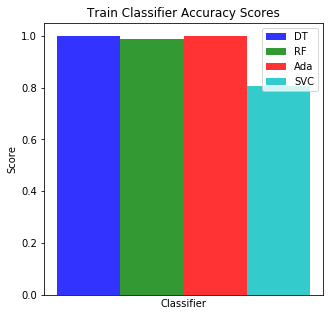

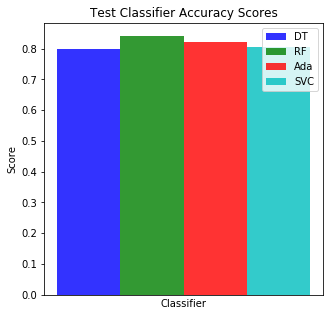

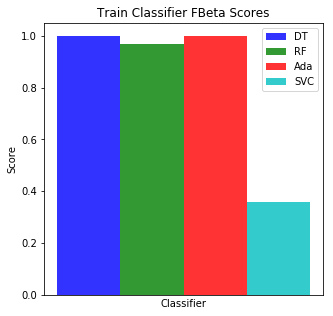

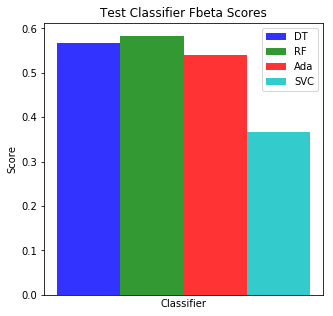

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, fbeta_score, f1_score

classifiers = [DecisionTreeClassifier(), RandomForestClassifier(), AdaBoostClassifier(DecisionTreeClassifier()), SVC()]

train_accuracy_scores = []
train_fbeta_scores = []
test_accuracy_scores = []
test_fbeta_scores = []


for clf in classifiers:
    clf = clf.fit(X_train, y_train)
    train_y_pred = clf.predict(X_train)
    test_y_pred = clf.predict(X_test)
    
    # Calculate Accuracy Score
    train_accuracy_scores.append(accuracy_score(train_y_pred, y_train))
    test_accuracy_scores.append(accuracy_score(test_y_pred, y_test))
    
    # Calculate Beta Score
    train_fbeta_scores.append(f1_score(y_train, train_y_pred))
    test_fbeta_scores.append(f1_score(y_test, test_y_pred))
    

labels = ('DT', 'RF', 'Ada', 'SVC')
plot_side_by_side_bars(train_accuracy_scores, labels, 'Classifier', 'Score', 'Train Classifier Accuracy Scores')
plot_side_by_side_bars(test_accuracy_scores, labels, 'Classifier', 'Score', 'Test Classifier Accuracy Scores')
plot_side_by_side_bars(train_fbeta_scores, labels, 'Classifier', 'Score', 'Train Classifier FBeta Scores')
plot_side_by_side_bars(test_fbeta_scores, labels, 'Classifier', 'Score', 'Test Classifier Fbeta Scores')
#plot_side_by_side_bars(train_fbeta_scores, test_fbeta_scores, 'Train Beta', 'Test Beta', 'Classifier', 'Score', 'Classifier Beta Scores', ('DT', 'RF', 'Ada'))

In [56]:
# clf = RandomForestClassifier()
# clf.fit(X_train, y_train)

# train_y_pred = clf.predict(X_train)
# f1_score(y_train, train_y_pred)

# test_y_pred = clf.predict(X_test)
# f1_score(y_test, test_y_pred)

0.5882352941176471

In [66]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier()

scores = {}
scores['cv'] = []
scores['f1_score'] = []
for c in range(2, 21):
    scores['cv'].append(c)
    cross_val_scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=c)
    scores['f1_score'].append(cross_val_scores.mean())

cross_val_df = pd.DataFrame(scores)

In [67]:
cross_val_df.loc[cross_val_df['f1_score'].idxmax()]

cv          7.000000
f1_score    0.584494
Name: 5, dtype: float64

In [69]:
from sklearn.model_selection import cross_val_predict
test_y_pred = cross_val_predict(clf, X_test, y_test, cv=10)

f1_score(y_test, test_y_pred)

0.5405877218504509

In [23]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
#clf = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy", max_depth=2))
clf = DecisionTreeClassifier()
# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
#parameters = {'min_samples_leaf': [1, 10]}

parameters = {"max_depth": [2, 4, 8], "min_samples_split": [3, 5, 10, 15], "min_samples_leaf": [2, 5, 8, 12]}
# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
print(best_clf)
# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 1)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 1)))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=15,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Unoptimized model
------
Accuracy score on testing data: 0.8017
F-score on testing data: 0.5655

Optimized Model
------
Final accuracy score on the testing data: 0.8470
Final F-score on the testing data: 0.5982


In [14]:
importances = best_clf.feature_importances_
attributes = {'Feature': X_train.columns.tolist(), 'Importance Value': importances}
importance_df = pd.DataFrame(attributes)
top_10_features_df = importance_df.sort_values(by=['Importance Value'], ascending=False).head(20)

In [15]:
top_10_features = top_10_features_df['Feature'].unique().tolist()
print(top_10_features)

['Opportunity Amount (in USD)', 'Number of Contacts', 'Anonymous Variable 4', 'Anonymous Variable 2', 'Anonymous Variable 1', 'Anonymous Variable 3', 'First Contact Type_Email', 'Customer Size By Revenue_USD 0 - 9999', 'Revenue From Customer (in USD)_USD 0', 'State_Texas', 'Customer Size By Number of Employees_0 to 10', 'Competitor Type_None', 'State_Utah', 'State_Oregon', 'State_California', 'First Contact Type_Direct Contact by Salesperson', 'Customer Size By Revenue_USD 100000 - 249999', 'Brand_Ritz', 'Country_United States', 'Customer Size By Number of Employees_31 to 40']


In [63]:
# # Import functionality for cloning a model
# from sklearn.base import clone

# X_train_reduced = X_train[top_10_features]
# X_test_reduced = X_test[top_10_features]

# clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# # Make new predictions
# reduced_predictions = clf.predict(X_test_reduced)

# # Report scores from the final model using both versions of data
# print("Final Model trained on full data\n------")
# print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
# print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 1)))
# print("\nFinal Model trained on reduced data\n------")
# print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
# print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 1)))

Final Model trained on full data
------
Accuracy on testing data: 0.8593
F-score on testing data: 0.6568

Final Model trained on reduced data
------
Accuracy on testing data: 0.8579
F-score on testing data: 0.6501


In [17]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier()
mlp_clf.fit(X_train[top_10_features], y_train)

mlp_predictions = mlp_clf.predict(X_test[top_10_features])
fbeta_score(y_test, mlp_predictions, beta = 1)

0.5288293535235877

In [77]:
y_pred_test = cross_val_predict(clf, X=test_final_features, cv=10)
print(np.array(y_pred_test))
np.savetxt("foo.csv", y_pred_test, delimiter=",")

TypeError: fit() missing 1 required positional argument: 'y'

TypeError: unhashable type: 'slice'

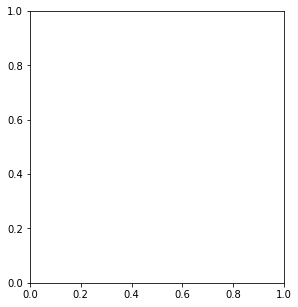

In [27]:
import matplotlib.pyplot as plt

bdt = best_clf
plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
X = X_train
y = y_train
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()